In [1]:
%matplotlib inline

import os
import cpi
import helper
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib.lines import Line2D

# General

### Federal Debt as Percent of GDP
Historical data from [here](https://www.longtermtrends.net/us-debt-to-gdp/) and projections from [CBO](https://www.cbo.gov/system/files/2023-09/59512-GrossDebt)

In [2]:
total_federal_debt = pd.read_csv("../raw_data/government/government-total-public.csv")
total_federal_debt["Date"] = pd.to_datetime(total_federal_debt["Date"])

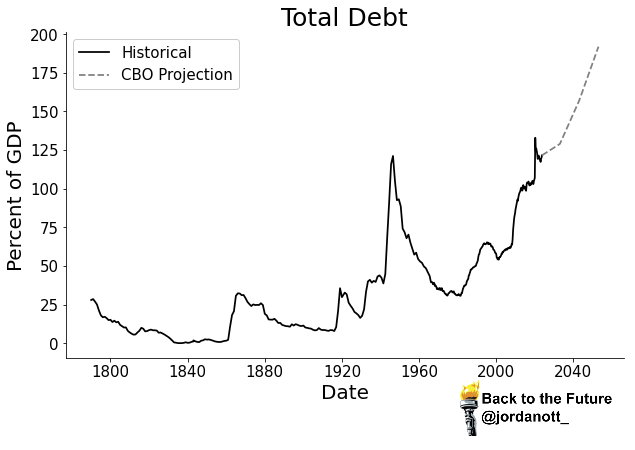

In [3]:
ax = sns.lineplot(x="Date", y="Total Public Debt to GDP Ratio", data=total_federal_debt.iloc[:-3], color="black", label="Historical")
sns.lineplot(x="Date", y="Total Public Debt to GDP Ratio", data=total_federal_debt.iloc[-4:], ls="--", label="CBO Projection", color="gray")

helper.create_legend()

plt.ylabel("Percent of GDP")
plt.title("Total Debt")

helper.add_logo(ax=ax)

helper.savefig("../images/federal_debt_as_percent_of_gdp")

## Median Wages vs Real GDP per Capita
* Median wages pulled from [here](https://docs.google.com/spreadsheets/d/14LXh9kOZk8DF_gZxpS6ljgKf2PoTHwGtTVc4_6PTJxA/edit#gid=1618676625)
* Real GDP per capita from [FRED](https://fred.stlouisfed.org/series/A939RX0Q048SBEA)

In [4]:
real_gdp_per_capita = pd.read_csv("../raw_data/government/real_gdp_per_capita.csv")
real_gdp_per_capita.Date = pd.to_datetime(real_gdp_per_capita.Date)

real_gdp_per_capita = helper.percent_change_relative_to(real_gdp_per_capita, "1947-01-01", "Real GDP per Capita")

In [5]:
median_wages = pd.read_csv("../raw_data/median_wages.txt", sep="|")
median_wages["Date"] = pd.to_datetime(median_wages["Year"], format='%Y')
median_wages = median_wages.sort_values(by="Date").reset_index(drop=True)

median_wages = helper.percent_change_relative_to(median_wages, date="1960-01-01", column_name="Median earnings (FtM)")
median_wages["Percent Change"] = real_gdp_per_capita[median_wages.Date[0] == real_gdp_per_capita.Date]["Percent Change"].values[0] + median_wages["Percent Change"]

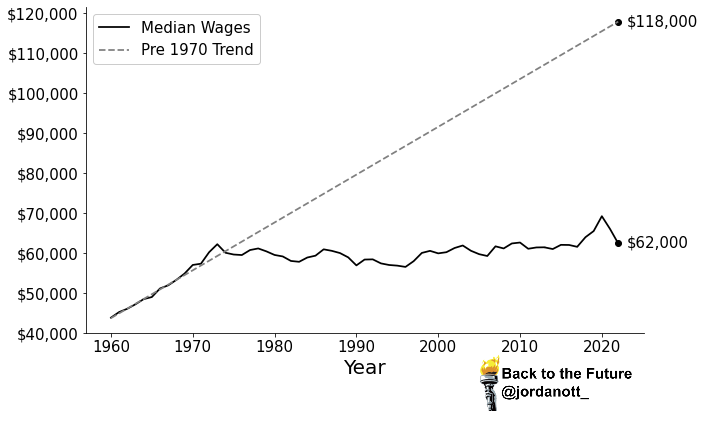

In [6]:
index = 10

x = median_wages.Year.values
y = median_wages["Median earnings (FtM)"].values

pre_1970 = linear_model.LinearRegression()
pre_1970.fit(x[:index, None], y[:index])
pre_1970_trend = pre_1970.predict(x[:, None])

post_1970 = linear_model.LinearRegression()
post_1970.fit(x[index:, None], y[index:])
post_1970_trend = post_1970.predict(x[index:, None])

ax = plt.subplot()
plt.plot(x, y, color="black", label="Median Wages")
plt.plot(x, pre_1970_trend, ls="--", label="Pre 1970 Trend", color="gray")
# plt.plot(x[index:], post_1970_trend, ls="--", label="Post 1970 trend")

for values in [pre_1970_trend, y]:
    last_year_value = int(round(values[-1], -3))
    plt.scatter(x[-1], values[-1], color="black")
    plt.text(x[-1] + 1, values[-1] - 1_000, f"${last_year_value:,}", fontsize=15)

ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

plt.xlabel("Year")
helper.create_legend()
helper.add_logo(ax=ax);

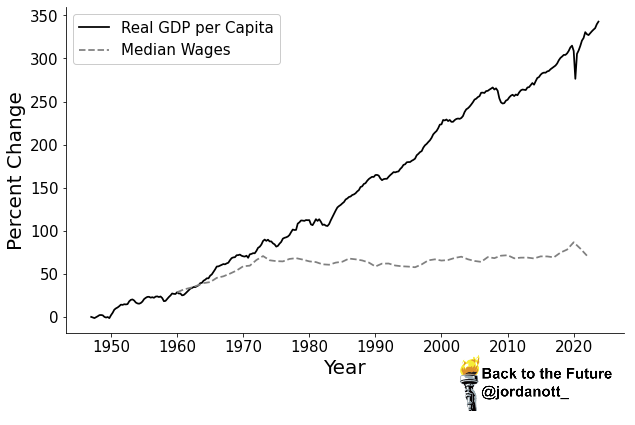

In [7]:
ax = sns.lineplot(x="Date", y="Percent Change", data=real_gdp_per_capita, label="Real GDP per Capita", color="black")
sns.lineplot(x="Date", y="Percent Change", data=median_wages, label="Median Wages", color="gray", ls="--")

helper.create_legend()
plt.xlabel("Year")

helper.add_logo(ax=ax)

helper.savefig("../images/median_wages_vs_real_gdp_per_capita")

## Household Income
Raw data pulled from [here](https://www2.census.gov/programs-surveys/demo/tables/p60/279/tableA4.xlsx)

In [8]:
percentiles = ["20", "50 (Median)", "95"]
household_income = pd.read_csv("../raw_data/household_income.txt", sep="|").drop(columns=["90th/10th", "90th/50th", "50th/10th"])

household_income = household_income[["Year"] + percentiles]
household_income = pd.melt(household_income, id_vars=["Year"], var_name="Percentile", value_name="Income")

household_income["Date"] = pd.to_datetime(household_income["Year"], format='%Y')
household_income = household_income.sort_values(by="Date").reset_index(drop=True)

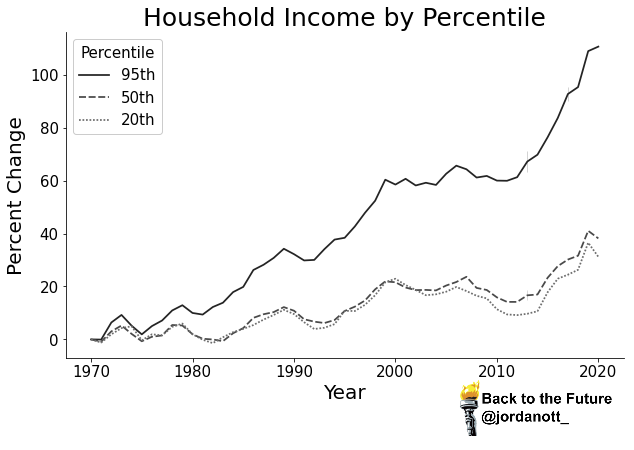

In [9]:
combined = pd.DataFrame()
for percentile in percentiles[::-1]:
    df = household_income[household_income.Percentile == percentile].reset_index(drop=True)
    df = helper.percent_change_relative_to(df, "1970-01-01", "Income")
    combined = pd.concat([combined, df])

combined.Percentile = combined.Percentile.str.replace("20", "20th")
combined.Percentile = combined.Percentile.str.replace("50 (Median)", "50th")
combined.Percentile = combined.Percentile.str.replace("95", "95th")

ax = sns.lineplot(
    x="Date", 
    y="Percent Change", 
    data=combined, 
    hue="Percentile",
    palette=sns.color_palette("gray", 6)[:3], 
    style="Percentile",
)

plt.title("Household Income by Percentile")
plt.xlabel("Year")

helper.add_logo(ax=ax)
helper.create_legend(title="Percentile")

helper.savefig("../images/household_income_by_percentile")

## Population

In [10]:
population = pd.read_csv("../raw_data/government/population.csv")
population = population.sort_values("Year").reset_index(drop=True)

# Regulation

## Banking

### Banks
Historical bank data from [FDIC](https://banks.data.fdic.gov/explore/historical/?displayFields=STNAME%2CTOTAL%2CBRANCHES%2CNew_Char&selectedEndDate=2023&selectedReport=CBS&selectedStartDate=1934&selectedStates=0&sortField=YEAR&sortOrder=desc)

In [11]:
banks = pd.read_csv("../raw_data/government/banking/bank-data.csv")

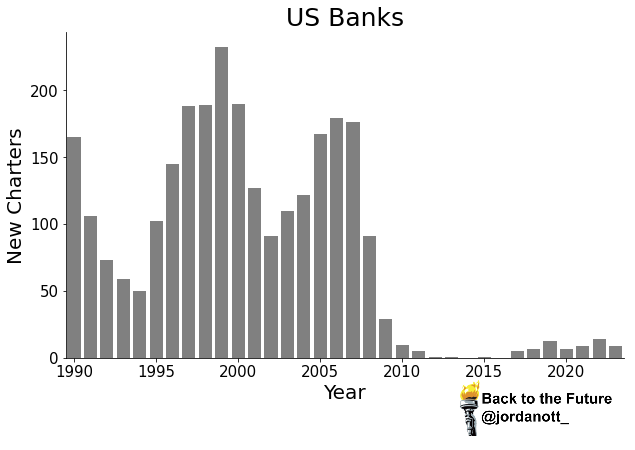

In [12]:
banks_since_1990 = banks.iloc[:34]

ax = sns.barplot(x="Year", y="New Charters", data=banks_since_1990, color="gray")
plt.xticks(range(0, len(banks_since_1990), 5), banks_since_1990.Year.values[::-5]);
plt.title("US Banks")

helper.add_logo(ax)

helper.savefig("../images/new_banks")

### Consumer Price Index (CPI)
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SA0?years_option=all_years) 

In [13]:
cpi_data = pd.read_excel("../raw_data/government/cpi.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
cpi_data = helper.format_year_month_table(cpi_data, "CPI")

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [14]:
dates = [datetime.datetime.utcfromtimestamp((x - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')) for x in cpi_data.Date.values][:-6]
purchasing_power = np.array([cpi.inflate(1, date, to=datetime.date(2024, 6, 1)) for date in dates])

In [15]:
crop = 200
one_dollar = plt.imread("../raw_data/government/banking/one_dollar.jpg")[200:-250, 200:-260]
one_dollar = np.concatenate([one_dollar / 255., np.ones(one_dollar.shape[:2] + (1,))], axis=-1)

In [16]:
column_width = one_dollar.shape[1] / len(dates)
column_indices = column_width * np.arange(len(dates))
column_indices = column_indices.astype(int)

row_spacing = one_dollar.shape[0] / purchasing_power[0]

x, y = [], []
for index in range(len(purchasing_power)):
    row_index = one_dollar.shape[0] - int(purchasing_power[index] * row_spacing)

    start = column_indices[index]
    end = one_dollar.shape[1]
    if index != len(purchasing_power) - 1:
        end = column_indices[index+1]

    one_dollar[:row_index, start:end] = np.nan # [0, 0, 0, 0]
    x.append(row_index)
    y.append(start)

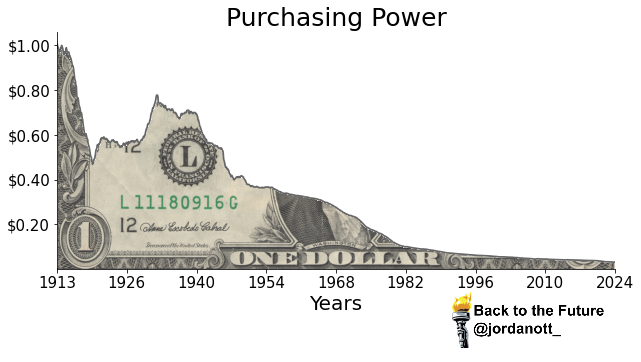

In [17]:
fig, ax = plt.subplots()

plt.imshow(one_dollar)
plt.plot(y, x, color=(0.4, 0.4, 0.4))
plt.title("Purchasing Power")
plt.xlabel("Years")
plt.xticks(np.linspace(20, one_dollar.shape[1], 9), np.linspace(1913, 2024, 9).astype(int));

plt.xlim(20, one_dollar.shape[1])
y_labels = [f"${label:.2f}" for label in np.linspace(0.2, 1, 5).round(3)[::-1]]
plt.yticks(np.linspace(0, one_dollar.shape[0], 6)[:-1], y_labels);

helper.add_logo(ax=ax, location=(0.85, -0.21))

helper.savefig("../images/purchasing_power")

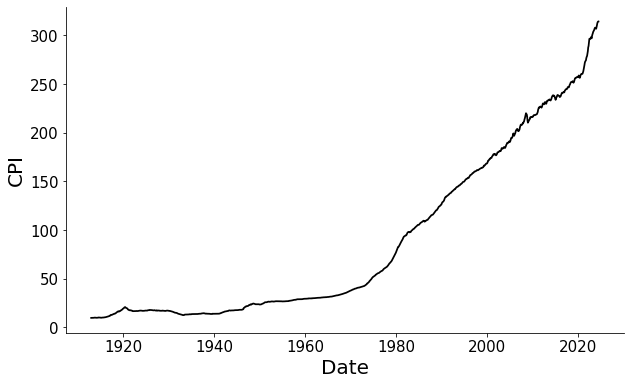

In [18]:
sns.lineplot(x="Date", y="CPI", data=cpi_data, color="black");

### Money Supply
Data from FRED

In [19]:
m0 = pd.read_csv("../raw_data/government/banking/monetary_base.csv")
m0["Date"] = pd.to_datetime(m0["Date"], format="mixed")
m0["Billions of Dollars"] = m0["Millions of Dollars"] / 1_000

m1 = pd.read_csv("../raw_data/government/banking/m1.csv")
m1["Date"] = pd.to_datetime(m1["Date"], format="mixed")

m2 = pd.read_csv("../raw_data/government/banking/m2.csv")
m2["Date"] = pd.to_datetime(m2["Date"], format="mixed")

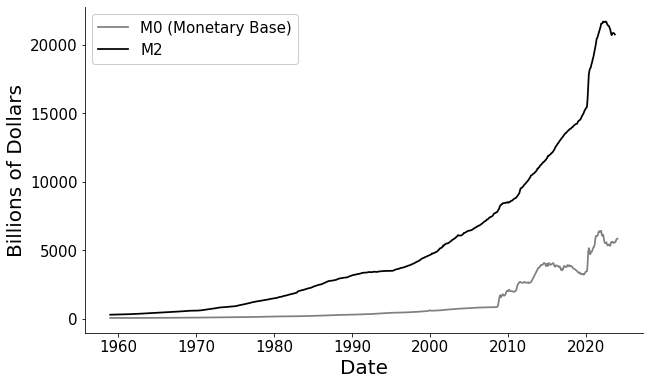

In [20]:
sns.lineplot(x="Date", y="Billions of Dollars", data=m0, label="M0 (Monetary Base)", color="gray")
# sns.lineplot(x="Date", y="Billions of Dollars", data=m1)
sns.lineplot(x="Date", y="Billions of Dollars", data=m2, label="M2", color="black")

helper.create_legend()

helper.savefig("../images/money_supply")

## Aviation

### Airports
Data from the [Bureau of Transportation Statistics](https://www.bts.gov/content/number-us-airportsa)

In [21]:
airports = pd.read_csv("../raw_data/government/aviation/airports.txt")

Text(0, 0.5, 'Public Airports')

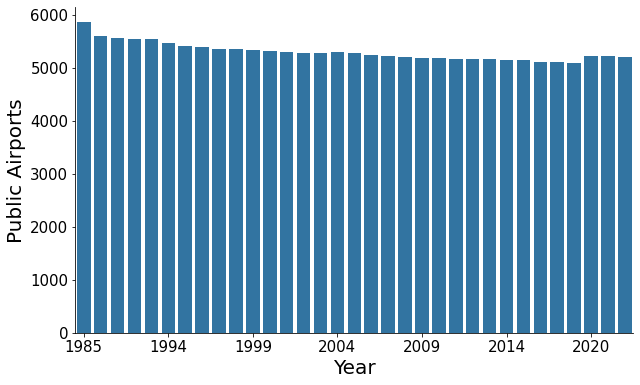

In [22]:
ax = sns.barplot(x="Year", y="Public", data=airports)

ax.set_xticks(range(0, len(airports), 5), airports.Year.values[::5])
plt.ylabel("Public Airports")

### 200 busiest airports
Airport rankings pulled from [BTS](https://www.bts.gov/topics/airlines-and-airports/airport-rankings-2022) airport dates found manually

In [23]:
airports = pd.read_excel("../raw_data/government/aviation/top_200_airports.xlsx", skiprows=2)
airports.Opened = airports.Opened.fillna(0.0).astype(int)
airports = airports.replace(0, None)

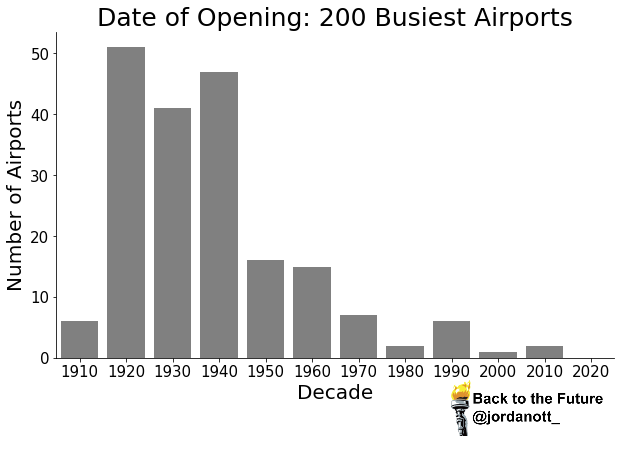

In [24]:
counts = airports["Opened"].value_counts().to_frame().reset_index().sort_values(by="Opened")
counts = counts.groupby((counts["Opened"]//10)*10).sum().drop(columns=["Opened"]).reset_index()
counts = pd.concat([counts, pd.DataFrame({"Opened": [2020], "count": [0]})])

ax = sns.barplot(x="Opened", y="count", data=counts, color="gray")
plt.xlabel("Decade")
plt.title("Date of Opening: 200 Busiest Airports", fontsize=25)
plt.ylabel("Number of Airports")

helper.add_logo(ax=ax)

helper.savefig("../images/busiest_airport_opening")

### Commercial Aviation Fatalities Over Time
Raw data pulled from [here](https://en.wikipedia.org/wiki/List_of_fatal_accidents_and_incidents_involving_commercial_aircraft_in_the_United_States)  
General aviation data available [here](https://www.bts.gov/content/us-general-aviationa-safety-data)

In [25]:
df = pd.read_csv("../raw_data/government/aviation/List_of_fatal_accidents_and_incidents_involving_commercial_aircraft_in_the_United_States.csv", sep="\t")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df["Fatalities"] = df["Fatalities"].replace(",", "").astype(float)

# Remove September 11th flights
df = df[df["Date"] != "2001-09-11"]
df = df[df.Date > "1950-01-01"]
df.head()

,Date,Fatalities,Injuries,Survivors,Flight(s) or incident,Location,State or territory,Aircraft,Summary
0,2023-06-23,1.0,0,0,2023 San Antonio ground crew suicide incident,San Antonio,Texas,Airbus A319,A ground crewman was ingested into an engine o...
1,2022-12-31,1.0,0,0,2022 Montgomery ground crew incident,Montgomery,Alabama,Embraer 175,An airline worker was pulled into the engine o...
2,2022-09-04,10.0,0,0,2022 Mutiny Bay DHC-3 Otter crash,Mutiny Bay near Whidbey Island,Washington,de Havilland Canada DHC-3 Otter,"Carrying tourists, the seaplane nosedived and ..."
3,2020-05-07,1.0,0,58,Southwest Airlines Flight 1392,Austin,Texas,Boeing 737-700,A man who had illegally entered the airfield w...
4,2020-01-26,9.0,0,0,2020 Calabasas helicopter crash,Calabasas,California,Sikorsky S-76B,The chartered helicopter flight crashed in hea...


In [26]:
fatalities_per_decade = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
for year in range(1950, 2024):
    if len(fatalities_per_decade[fatalities_per_decade.Date == year]) != 0:
        continue 

    fatalities_per_decade.loc[-1] = [year, 0]
    fatalities_per_decade.index = fatalities_per_decade.index + 1
    fatalities_per_decade = fatalities_per_decade.sort_index()

    fatalities_per_decade = fatalities_per_decade.sort_values(by="Date").reset_index(drop=True)

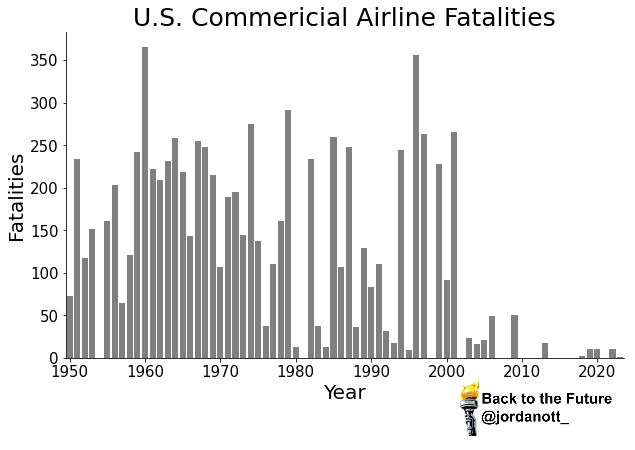

In [27]:
# fatalities_per_year = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
plt.title("U.S. Commericial Airline Fatalities", fontsize=25)
ax = sns.barplot(x="Date", y="Fatalities", data=fatalities_per_decade, color="gray")

years = sorted(fatalities_per_decade["Date"].unique())
ax.set_xticks(range(0, len(years), 10), years[::10]);
plt.xlabel("Year")

helper.add_logo(ax=ax)

helper.savefig("../images/us_commercial_airline_fatalities")

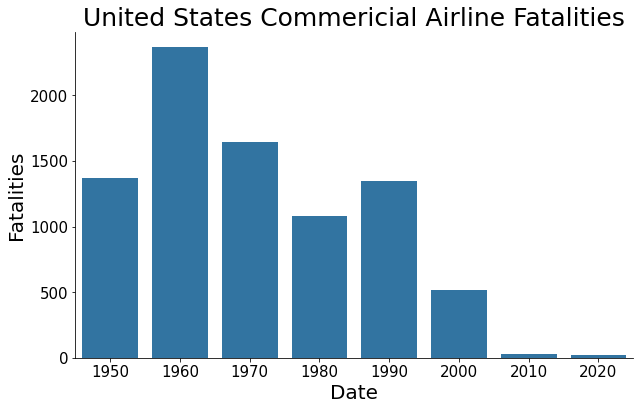

In [28]:
fatalities_per_decade = df["Fatalities"].groupby((df["Date"].dt.year//10)*10).sum().reset_index()
# fatalities_per_year = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
plt.title("United States Commericial Airline Fatalities", fontsize=25)
sns.barplot(x="Date", y="Fatalities", data=fatalities_per_decade);

### Commercial Airplane Speeds Over Time
Data was manually collected

In [29]:
commercial_airplane_speeds = pd.read_csv("../raw_data/government/aviation/commercial_airplane_speeds.txt")
commercial_airplane_speeds.head()

,Plane,Year,Cruise Speed,Top Speed,Source
0,B-247,1933,189,200,https://g.co/kgs/76ALY6
1,DC-3,1935,207,257,https://g.co/kgs/hTVUaT
2,DC-4,1942,227,280,https://g.co/kgs/estQje
3,L-749,1947,275,347,https://aeropedia.com.au/content/lockheed-l-7...
4,DC-6,1947,311,315,https://en.wikipedia.org/wiki/Douglas_DC-6


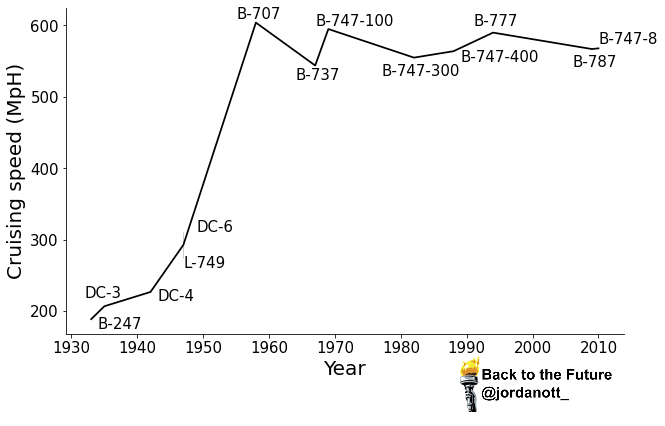

In [30]:
offsets = {
    "B-247": (1, -13),
    "DC-3": (-3, 12),
    "DC-4": (1, -12),
    "DC-6": (2, 0),
    "L-749": (0, -14),
    "B-707": (-3, 5),
    "B-737": (-3, -20),
    "B-747-100": (-2, 5),
    "B-747-300": (-5, -25),
    "B-747-400": (1, -15),
    "B-777": (-3, 10),
    "B-747-8": (0, 6),
    "B-787": (-3, -25)
}

ax = sns.lineplot(x="Year", y="Cruise Speed", data=commercial_airplane_speeds, color='black')
for _, row in commercial_airplane_speeds.iterrows():
    x_offset, y_offset = offsets.get(row["Plane"], (0, 0))
    ax.text(row.Year + x_offset, row["Cruise Speed"] + y_offset, row.Plane, fontsize=15)

plt.ylabel("Cruising speed (MpH)")

helper.add_logo(ax=ax)

helper.savefig("../images/commercial_aviation_speeds")

### Prices
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SETG01?output_view=data)

In [31]:
airline_fares = pd.read_excel("../raw_data/government/aviation/airline_fares.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
airline_fares = helper.format_year_month_table(airline_fares)

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [32]:
cpi_relative_to_1970 = helper.percent_change_relative_to(cpi_data, date="1970-01-01", column_name="CPI")
airline_fares_relative_to_1970 = helper.percent_change_relative_to(airline_fares, date="1970-01-01", column_name="Value")

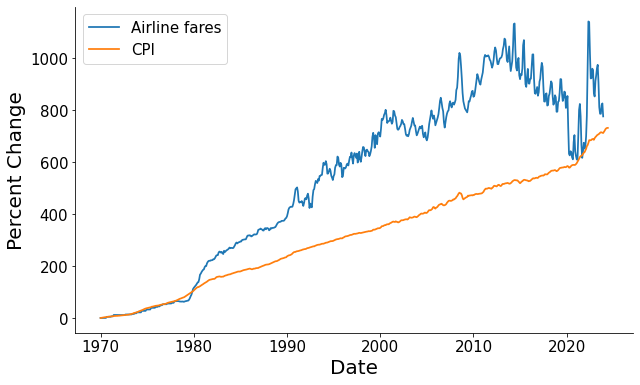

In [33]:
sns.lineplot(x="Date", y="Percent Change", data=airline_fares_relative_to_1970, label="Airline fares")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1970, label="CPI");

### General Aviation Planes
Raw data pulled from [here](https://gama.aero/facts-and-statistics/statistical-databook-and-industry-outlook/annual-data/)

In [34]:
general_aviation_plane_shipments = pd.read_csv("../raw_data/government/aviation/general_aviation_plane_shipments.txt", sep="\t")
general_aviation_plane_shipments["Grand Total"] = general_aviation_plane_shipments["Grand Total"].str.replace(' ', '').str.replace(",", "").astype(int)

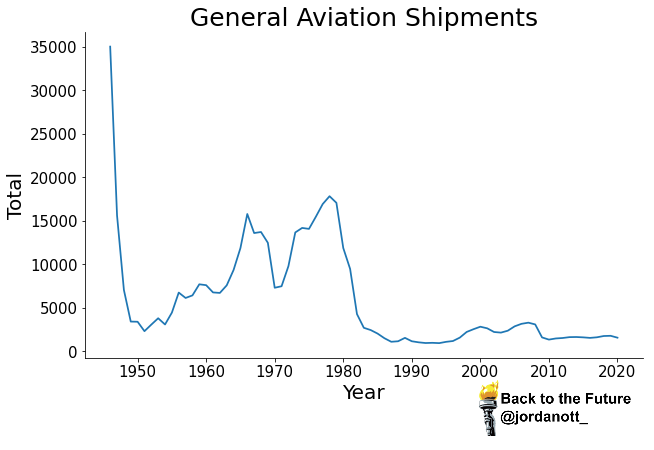

In [35]:
ax = sns.lineplot(x="Year", y="Grand Total", data=general_aviation_plane_shipments);

plt.ylabel("Total")
plt.title("General Aviation Shipments")

helper.add_logo(ax=ax)

## Construction

### Building Cost Index
Raw data pulled from [here](https://www.enr.com/economics/historical_indices/building_cost_index_history)

In [36]:
building_cost_index_annual_average = pd.read_csv("../raw_data/government/construction/building_cost_index_annual_average.txt")
building_cost_index_annual_average["Date"] = pd.to_datetime(building_cost_index_annual_average["Year"], format='%Y')

In [37]:
building_cost_index = pd.read_csv("../raw_data/government/construction/building_cost_index.txt").drop(columns=["AVG"])
building_cost_index = helper.format_year_month_table(building_cost_index, "BCI")

building_cost_index = pd.concat([building_cost_index, building_cost_index_annual_average])
building_cost_index = building_cost_index.sort_values(by="Date").reset_index(drop=True)

In [38]:
cpi_relative_to_1960 = helper.percent_change_relative_to(cpi_data, date="1960-01-01", column_name="CPI")
building_cost_index_relative_to_1960 = helper.percent_change_relative_to(building_cost_index, date="1960-01-01", column_name="BCI")

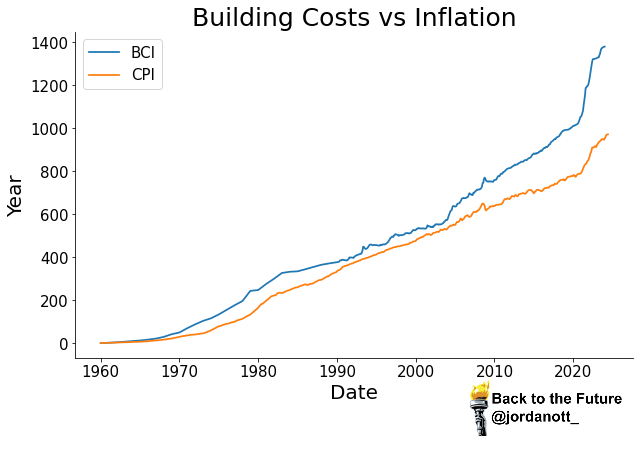

In [39]:
ax = sns.lineplot(x="Date", y="Percent Change", data=building_cost_index_relative_to_1960, label="BCI")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1960, label="CPI");

plt.ylabel("Year")
plt.title("Building Costs vs Inflation")

helper.add_logo(ax=ax)

### Housing
#### Median home price
Data pulled from [FRED](https://fred.stlouisfed.org/series/MSPUS)

In [40]:
median_home_price = pd.read_csv("../raw_data/government/median_home_price.csv")
median_home_price["Date"] = pd.to_datetime(median_home_price["Date"], format="mixed")
median_home_price = median_home_price["Median Home Price"].groupby(median_home_price["Date"].dt.year).mean().reset_index()

median_home_price = median_home_price.rename(columns={"Date": "Year"})

# Adjust for inflation
median_home_price["Median Home Price"] = median_home_price.apply(
    lambda x: cpi.inflate(x["Median Home Price"], int(x.Year), to=2023), axis=1
)

<Axes: xlabel='Year', ylabel='Median Home Price'>

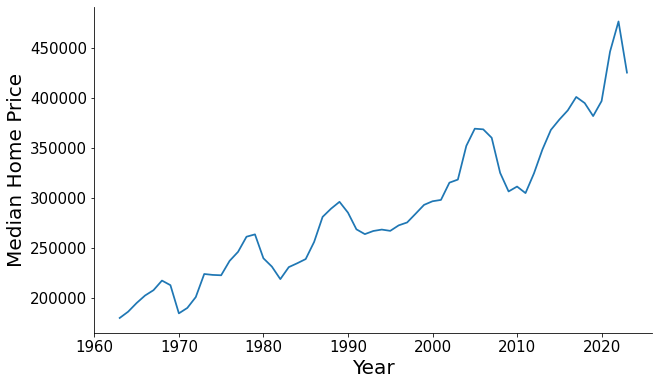

In [41]:
sns.lineplot(x="Year", y="Median Home Price", data=median_home_price)

<Axes: xlabel='Year', ylabel='Percent Change'>

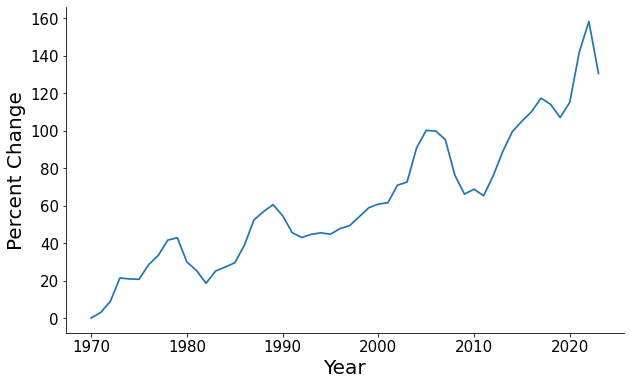

In [42]:
median_home_price = helper.percent_change_relative_to(median_home_price, 1970, "Median Home Price")
sns.lineplot(x="Year", y="Percent Change", data=median_home_price)

#### San Francisco, California, and US Median Prices

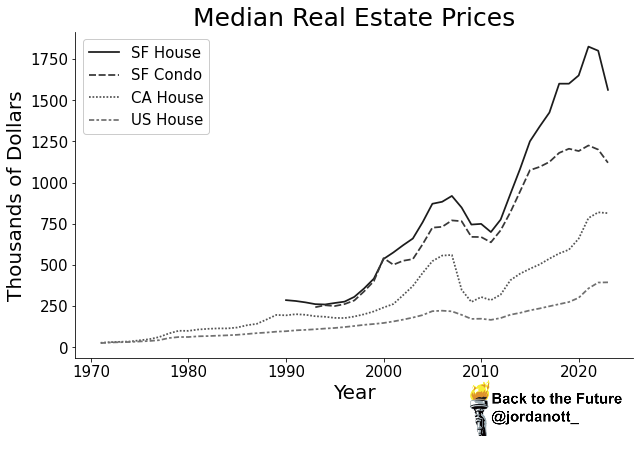

In [43]:
sf_ca_us_median_home_prices = pd.read_csv("../raw_data/government/sf_ca_us_median_home_prices.csv")

for column in sf_ca_us_median_home_prices.columns[1:]:
    sf_ca_us_median_home_prices[column] /= 1_000

sf_ca_us_median_home_prices = pd.melt(sf_ca_us_median_home_prices, id_vars=["Year"], var_name="Type", value_name="Value")
sf_ca_us_median_home_prices.Type = sf_ca_us_median_home_prices.Type.str.replace("San Francisco Median Existing House Price", "SF House")
sf_ca_us_median_home_prices.Type = sf_ca_us_median_home_prices.Type.str.replace("San Francisco Median Condo Price", "SF Condo")
sf_ca_us_median_home_prices.Type = sf_ca_us_median_home_prices.Type.str.replace("CA Median Existing House Price", "CA House")
sf_ca_us_median_home_prices.Type = sf_ca_us_median_home_prices.Type.str.replace("US Median Existing House Price", "US House")

ax = sns.lineplot(
    x="Year", 
    y="Value", 
    data=sf_ca_us_median_home_prices, 
    hue="Type",
    palette=sns.color_palette("gray", 8)[:-4], 
    style="Type",
)
helper.create_legend(title="")

plt.ylabel("Thousands of Dollars")
plt.title("Median Real Estate Prices")

helper.add_logo(ax=ax)

helper.savefig("../images/sf_ca_us_median_home_prices")

## Education

### Public school employement
Raw data pulled from [here](https://nces.ed.gov/programs/digest/d22/tables/dt22_213.10.asp)

In [44]:
public_school_employment = pd.read_csv("../raw_data/government/education/public_school_employment.txt")

In [45]:
public_school_employment["Students"] = public_school_employment["Teachers"] * public_school_employment["Teachers per student"]

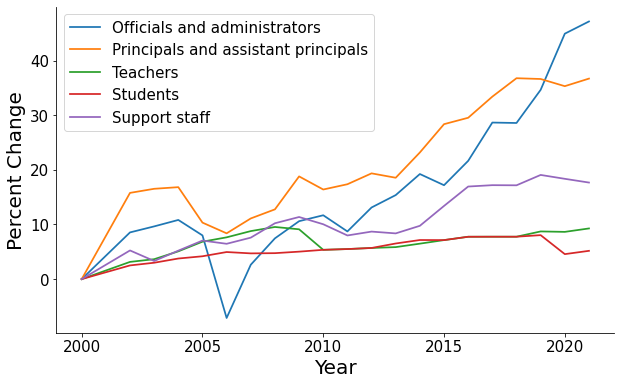

In [46]:
for column_name in ["Officials and administrators", "Principals and assistant principals", "Teachers", "Students", "Support staff"]:
    data = helper.percent_change_relative_to(public_school_employment, 2000, column_name)
    
    sns.lineplot(x="Year", y="Percent Change", data=data, label=column_name)

### Educational Attainment
Raw data pulled from [here](https://nces.ed.gov/programs/digest/d22/tables/xls/tabn104.20.xls)

In [47]:
educational_attainment = pd.read_csv("../raw_data/government/education/educational_attainment.txt")

educational_attainment["Date"] = pd.to_datetime(educational_attainment["Year"], format='%Y')
educational_attainment = educational_attainment.sort_values(by="Date").reset_index(drop=True)

In [48]:
# Bachelors degrees relative to 1970
bachelors_degree = educational_attainment[educational_attainment["Degree"] == "Bachelor's degree"]
bachelors_degree_relative_to_1970 = helper.percent_change_relative_to(bachelors_degree.reset_index(drop=True), "1970-01-01", "Percent")

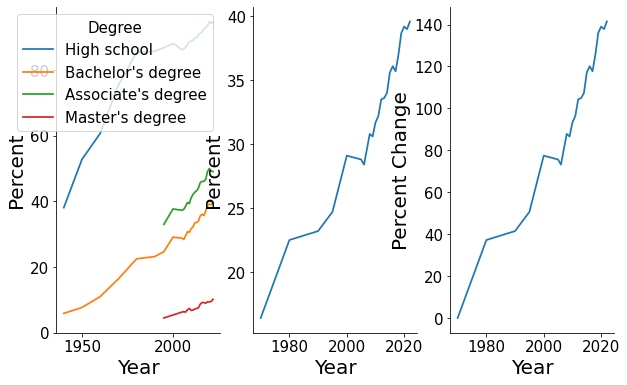

In [49]:
plt.subplot(1, 3, 1)
sns.lineplot(x="Year", y="Percent", data=educational_attainment, hue="Degree")

plt.subplot(1, 3, 2)
sns.lineplot(x="Year", y="Percent", data=bachelors_degree_relative_to_1970)

plt.subplot(1, 3, 3)
sns.lineplot(x="Year", y="Percent Change", data=bachelors_degree_relative_to_1970);

### College Tuition
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SEEB01?output_view=data)

In [50]:
college_tuition = pd.read_csv("../raw_data/government/education/college_tuition.csv")
college_tuition["Date"] = pd.to_datetime(college_tuition["Label"], format="mixed")

In [51]:
# Compute CPI relative to 1978 to match tuition data
cpi_relative_to_1978 = helper.percent_change_relative_to(cpi_data, date="1978-01-01", column_name="CPI")
college_tuition_relative_to_1978 = helper.percent_change_relative_to(college_tuition, date="1978-01-01", column_name="Value")

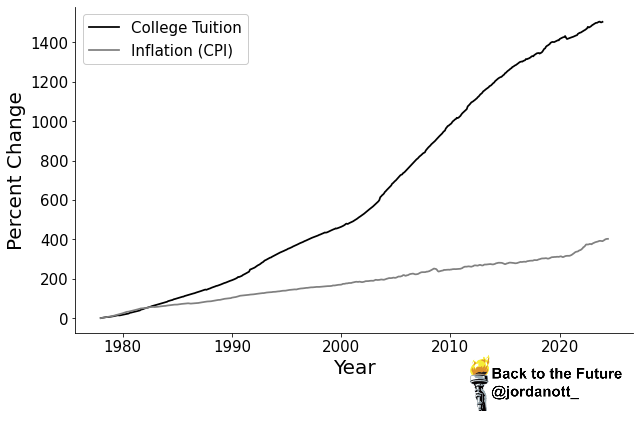

In [52]:
ax = sns.lineplot(x="Date", y="Percent Change", data=college_tuition_relative_to_1978, label="College Tuition", color="black")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1978, label="Inflation (CPI)", color="gray")
plt.xlabel("Year")

helper.create_legend()

helper.add_logo(ax=ax)

helper.savefig("../images/college_tuition")

### Student Loans
- Federal student loans from [portfolio summary](https://studentaid.gov/data-center/student/portfolio) | [table](https://studentaid.gov/sites/default/files/fsawg/datacenter/library/PortfolioSummary.xls)
- [Total student loans](https://educationdata.org/student-loan-debt-statistics)

In [53]:
federal_student_loans = pd.read_csv("../raw_data/government/education/student_loans.txt")
federal_student_loans["Date"] = pd.to_datetime(federal_student_loans["Date"], format="mixed")

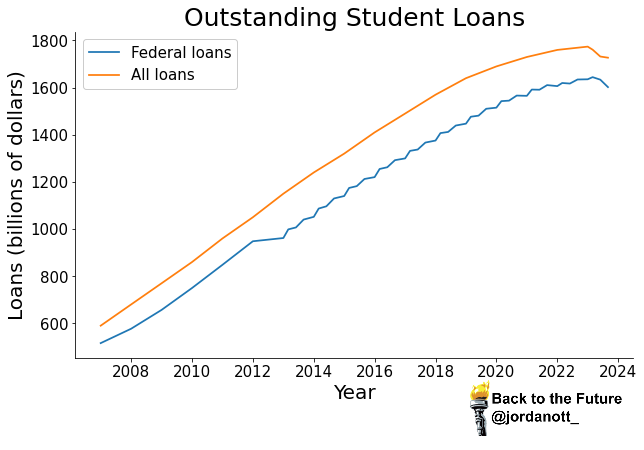

In [54]:
ax = sns.lineplot(x="Date", y="Dollars Outstanding (in billions)", data=federal_student_loans, label="Federal loans")
sns.lineplot(x="Date", y="Total", data=federal_student_loans, label="All loans")

helper.create_legend()

plt.ylabel("Loans (billions of dollars)")
plt.xlabel("Year")
plt.title("Outstanding Student Loans")

helper.add_logo(ax=ax)

helper.savefig("../images/student_loans")

### Enrollment
Raw data pulled from [here](https://educationdata.org/college-enrollment-statistics)

In [55]:
college_enrollment = pd.read_csv("../raw_data/government/education/college_enrollment.txt")

college_enrollment["Year"] = pd.to_datetime(college_enrollment["Year"], format='%Y')
college_enrollment = college_enrollment.sort_values(by="Year").reset_index(drop=True)
helper.percent_change_relative_to(college_enrollment, "1970-01-01", "Total Enrollment").tail()

,Year,Total Enrollment,Percent Public Institution Enrollment,Percent Change
53,2019-01-01,19630178,73.88,128.766304
54,2020-01-01,19027410,72.97,121.741762
55,2021-01-01,18659851,72.58,117.458300
56,2022-01-01,18961280,73.12,120.971095
57,2023-01-01,18939568,73.19,120.718068


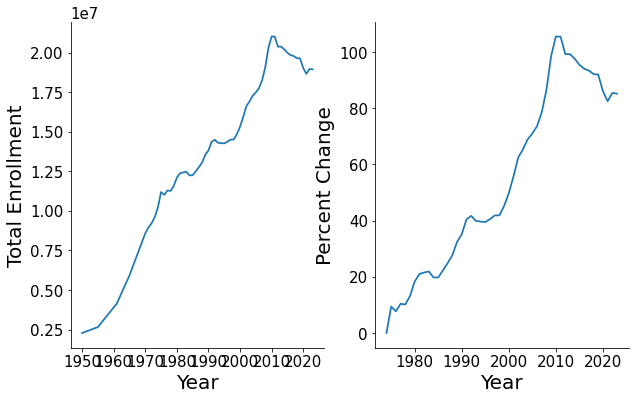

In [56]:
plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="Total Enrollment", data=college_enrollment)

plt.subplot(1, 2, 2)
college_enrollment = helper.percent_change_relative_to(college_enrollment, "1974-01-01", "Total Enrollment")
sns.lineplot(x="Year", y="Percent Change", data=college_enrollment);

### Secondary Institutions
Raw data pulled from here [here](https://nces.ed.gov/programs/digest/d22/tables/dt22_317.10.asp)

In [57]:
secondary_institutions = pd.read_excel("../raw_data/government/education/post_secondary_institutions.xlsx", header=3)

secondary_institutions["Year"] = secondary_institutions["Year"].apply(lambda x: x.split("-")[0])
secondary_institutions["Date"] = pd.to_datetime(secondary_institutions["Year"], format='%Y')
secondary_institutions = secondary_institutions.sort_values(by="Date").reset_index(drop=True)

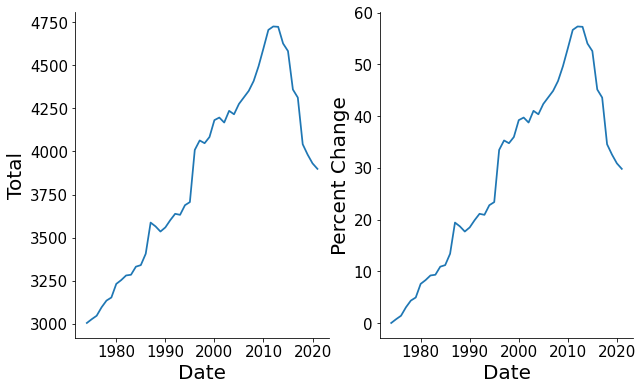

In [58]:
secondary_institutions = helper.percent_change_relative_to(secondary_institutions, "1974-01-01", "Total")

plt.subplot(1, 2, 1)
sns.lineplot(x="Date", y="Total", data=secondary_institutions)

plt.subplot(1, 2, 2)
sns.lineplot(x="Date", y="Percent Change", data=secondary_institutions);

## Energy

### Energy Consumption
Raw data pulled from [here](https://www.eia.gov/energyexplained/us-energy-facts/) and [here](https://www.eia.gov/totalenergy/data/monthly/xls/Table_D1.xlsx)

In [59]:
estimated_energy_consumption = pd.read_csv("../raw_data/government/energy/estimated_energy_consumption.csv")

energy_consumption = pd.read_csv("../raw_data/government/energy/primary-consumption-by-major-source.csv")
ENERGY_TYPES = ["Coal", "Natural gas", "Petroleum", "Nuclear", "Renewables"]
energy_consumption["Total"] = energy_consumption[ENERGY_TYPES].sum(axis=1)

energy_consumption = pd.concat([estimated_energy_consumption, energy_consumption])
energy_consumption = pd.melt(energy_consumption, id_vars=["Year"], var_name="Type", value_name="Quads")
energy_consumption = energy_consumption.loc[energy_consumption["Type"].isin(ENERGY_TYPES)]

total_consumption = energy_consumption.drop(columns=["Type"]).groupby("Year").sum().reset_index()

<Axes: xlabel='Year', ylabel='Quads'>

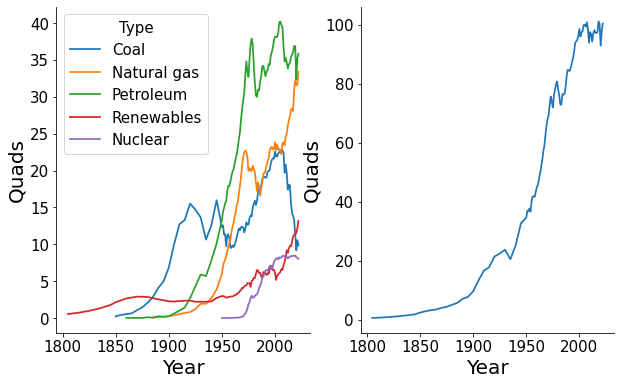

In [60]:
plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="Quads", data=energy_consumption, hue="Type")

plt.subplot(1, 2, 2)
sns.lineplot(x="Year", y="Quads", data=total_consumption)

### Energy Consumption Per Capita

In [61]:
for index, row in total_consumption.iterrows():
    population_index = np.argmin(np.abs(population.Year.values - row.Year))
    total_consumption.at[index, "Per Capita"] = row.Quads / population.iloc[population_index].Population

QUADS_TO_KWH = 293071083333.33
total_consumption["Per Capita"] *= QUADS_TO_KWH

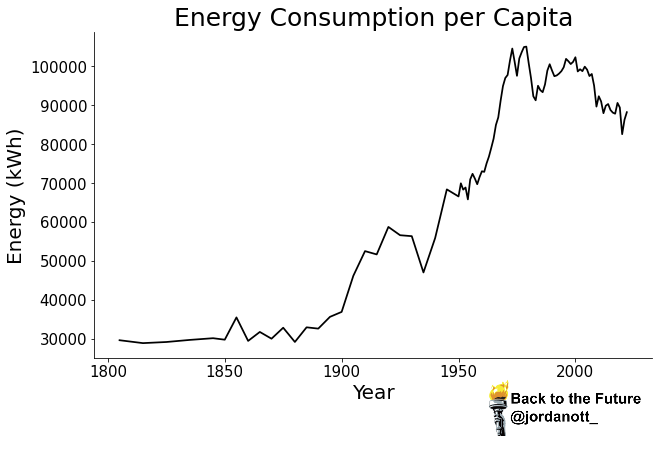

In [62]:
ax = sns.lineplot(x="Year", y="Per Capita", data=total_consumption, color="black")
plt.ylabel("Energy (kWh)")
plt.title("Energy Consumption per Capita")

helper.add_logo(ax=ax)

helper.savefig("../images/energy_per_capita")

### Nuclear reactor cost
Data provided from authors

In [63]:
reactors = pd.read_excel("../raw_data/government/energy/Lovering2016_OCC_Nuclear_Seven_Countries.xlsx", header=0)
reactors = reactors[reactors.Country == "US"].reset_index(drop=True)
reactors["Duration"] = reactors.Comm_Op_Year - reactors.Constr_Year
reactors["cost_per_mw"] = reactors["OCC"] / reactors["Capacity_MW"]

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


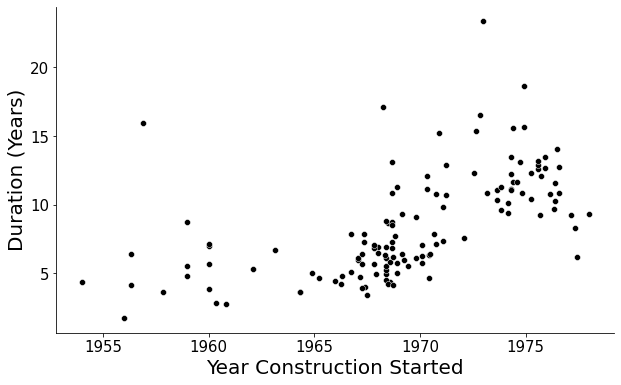

In [64]:
fig = plt.figure()
ax = fig.gca()
# ax.set_yticks(np.arange(2, 25))
# plt.grid()
sns.scatterplot(x="Constr_Year", y="Duration", data=reactors, color="black")

plt.ylabel("Duration (Years)")
plt.xlabel("Year Construction Started")

helper.savefig("../images/reactors_construction_year_vs_duration")

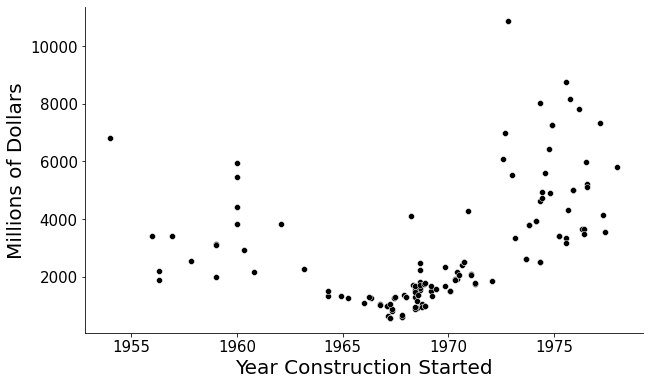

In [65]:
fig = plt.figure()
sns.scatterplot(x="Constr_Year", y="OCC", data=reactors, color="black")

plt.ylabel("Millions of Dollars")
plt.xlabel("Year Construction Started")

helper.savefig("../images/reactors_construction_year_vs_cost")

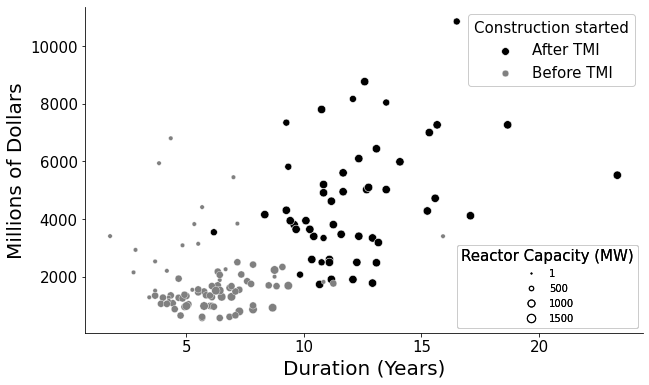

In [66]:
POINT_SIZES = [1, 20, 50, 70]
REACTOR_CAPACITY_BINS = [0, 1, 500, 1000, 1500]

reactors_after_tmi = reactors[reactors.Note == "Completed after TMI"]
point_size = pd.cut(reactors_after_tmi.Capacity_MW, bins=REACTOR_CAPACITY_BINS, labels=POINT_SIZES).values
sns.scatterplot(x="Duration", y="OCC", data=reactors_after_tmi, s=point_size, label="After TMI", color="black")

reactors_before_tmi = reactors[reactors.Note != "Completed after TMI"]
point_size = pd.cut(reactors_before_tmi.Capacity_MW, bins=REACTOR_CAPACITY_BINS, labels=POINT_SIZES).values
sns.scatterplot(x="Duration", y="OCC", data=reactors_before_tmi, s=point_size, label="Before TMI", color="grey")

plt.ylabel("Millions of Dollars")
plt.xlabel("Duration (Years)")

# First legend: construction started before/after TMI
legend = helper.create_legend(title="Construction started")
plt.gca().add_artist(legend)

# Add second legend: relate point size to reactor capacity
lines = []
for capacity, point_size in zip(REACTOR_CAPACITY_BINS[1:], POINT_SIZES):
    line = Line2D([0], [0], marker='o', markersize=np.sqrt(point_size), color='black', linestyle='None', fillstyle="none")
    lines.append(line)

legend = plt.legend(lines, REACTOR_CAPACITY_BINS[1:], loc="lower right", scatterpoints=1, fontsize=10, title="Reactor Capacity (MW)")
helper.create_legend(legend=legend)
plt.gca().add_artist(legend)

helper.savefig("../images/reactors_duration_vs_occ")

## Medical

Approvals data from [here](https://www.fda.gov/about-fda/histories-fda-regulated-products/summary-nda-approvals-receipts-1938-present)

Orphan data from [here](https://www.fda.gov/news-events/fda-voices/cder-continues-make-rare-diseases-priority-drug-approvals-and-programming-speed-therapeutic) and [here](https://www.raps.org/News-and-Articles/News-Articles/2020/1/FDA-2019-Continues-Uptick-in-Orphan-Drug-Approval)

[R&D Spending per year](https://www.cbo.gov/system/files/2021-04/57025-Data.xlsx)

In [67]:
fda_approvals = pd.read_csv("../raw_data/government/medical/fda_applications.txt").iloc[20:]
fda_approvals["Percent Orphans"] = fda_approvals["Orphans"] / fda_approvals["New Molecular Entities"]

<Axes: xlabel='Year', ylabel='Percent Orphans'>

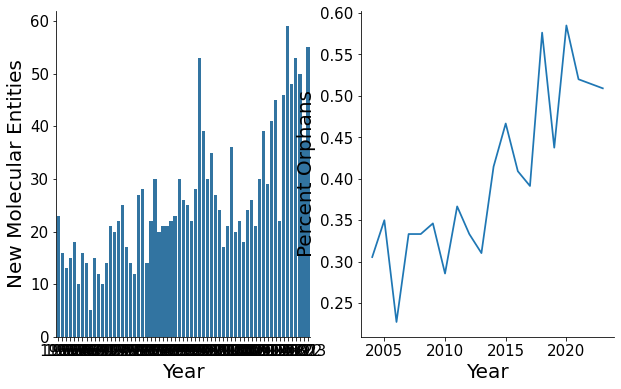

In [68]:
plt.subplot(1, 2, 1)
sns.barplot(x="Year", y="New Molecular Entities", data=fda_approvals)

plt.subplot(1, 2, 2)
sns.lineplot(x="Year", y="Percent Orphans", data=fda_approvals)

### Life Expectancy
* 1850 - 1895 from [here](https://www.statista.com/statistics/1040079/life-expectancy-united-states-all-time/)
* 1900 - 2018 from [NCHS](https://www.cdc.gov/nchs/data-visualization/mortality-trends/index.htm)
* 2019 - 2022 from [CDC](https://stacks.cdc.gov/view/cdc/151563)

In [69]:
life_expectancy = pd.read_csv("../raw_data/government/medical/life_expectancy.txt").iloc[30:]
# 5 Year moving average
life_expectancy = life_expectancy.set_index("Year").rolling(window=2).mean().reset_index()

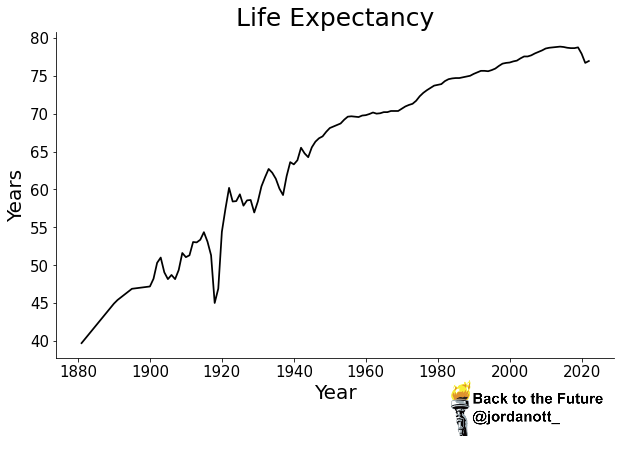

In [70]:
ax = sns.lineplot(x="Year", y="Life Expectancy (Years)", data=life_expectancy, color="black")
plt.title("Life Expectancy")
plt.ylabel("Years")
helper.add_logo(ax=ax)

helper.savefig("../images/life_expectancy")

## Railroads
### Passenger Train Spees

In [71]:
df = pd.read_csv("../raw_data/government/transportation/passenger_train_speeds.txt")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df.head()

,Km/H,MPH,Train,Location,Date,Comments,Country
0,200.0,120,Class 1000 Shinkansen,Kamonomiya test track in Odawara now part of T...,1962-10-31,NaN,Japan
1,256.0,159,Class 1000 Shinkansen,Kamonomiya test track,1963-03-30,Former world speed record for EMU trains.,Japan
2,286.0,178,Class 951 Shinkansen,San'yō Shinkansen,1972-02-24,Former world speed record for EMU trains.,Japan
3,319.0,198,Class 961 Shinkansen,Oyama test track now part of Tōhoku Shinkansen,1979-12-07,Former world speed record for EMU trains.,Japan
4,326.0,203,300 series,Tōkaidō Shinkansen,1991-02-28,NaN,Japan


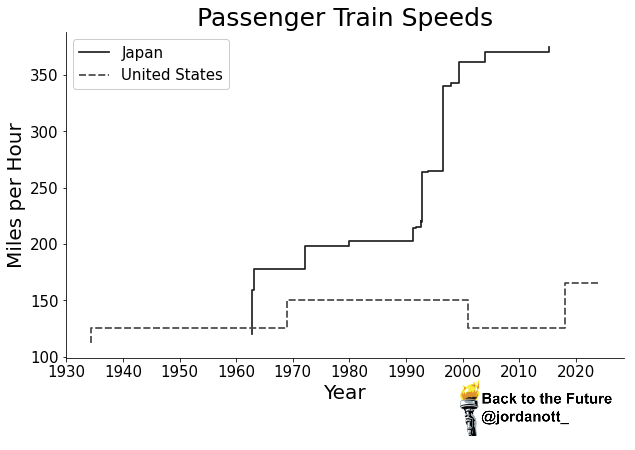

In [72]:
ax = sns.lineplot(
    x="Date", 
    y="MPH", 
    data=df, 
    hue="Country", 
    drawstyle="steps",
    palette=sns.color_palette("gray", 6)[:-4], 
    style="Country",
)
plt.title("Passenger Train Speeds")
plt.ylabel("Miles per Hour")
plt.xlabel("Year")

helper.create_legend()
helper.add_logo(ax=ax)

helper.savefig("../images/passenger_train_speeds")

## All
- [Television](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SERA01)
- [Airline fares](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SETG01)
- [Hospital services](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEMD01)
- [Transportation services](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SAS4)
- [Energy](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SA0E)
- [Cellphone services](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEED03)
- [Shelter](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SAH1)
- [New cars](https://beta.bls.gov/dataViewer/view/timeseries/CUSR0000SS45011)
- [Computers](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEEE01)
- [Computer software](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEEE02)
- [Medical care](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SAM)

In [73]:
sectors = [
    ["cellphone_services"],
    ["television"],
    ["energy", "energy"],
    ["medical", "hospital_services"],
    ["aviation", "airline_fares"],
    ["food"],
    ["computer_software"],
    ["new_cars"],
    ["computers"],
    ["medical", "medical_care"],
    ["education", "college_tuition"],
]

In [74]:
df = pd.DataFrame()

for description in sectors:
    path = os.path.join(*description)
    data = pd.read_csv(f"../raw_data/government/{path}.csv")
    data["Label"] = data["Label"].replace({"Half1": "Jan", "Half2": "Jul"}, regex=True)
    
    data["Date"] = pd.to_datetime(data['Label'], format='%Y %b')
    data["Category"] = description[-1]
    data = helper.percent_change_relative_to(data, "2000-01-01", "Value")
    df = pd.concat([df, data])

In [75]:
data = building_cost_index.rename(columns={"BCI": "Value"}).dropna().reset_index(drop=True)
data["Category"] = "Building"
building_cost_index_relative_to_2000 = helper.percent_change_relative_to(data, date="2000-01-01", column_name="Value")
df = pd.concat([df, building_cost_index_relative_to_2000])

In [76]:
cpi_relative_to_2000 = helper.percent_change_relative_to(cpi_data, "2000-01-01", "CPI")

In [77]:
offsets = {
    "energy": 2,
    "Building": -6,
    "medical_care": -4,
    "food": -5,
    "television": -8,
    "shelter": -2,
    "airline_fares": -5,
}

In [78]:
sorted_categories = df[df["Date"] == "2023-12-01"].sort_values(by="Percent Change").Category.unique().tolist()
color_palette = sns.color_palette("gray", len(sorted_categories))

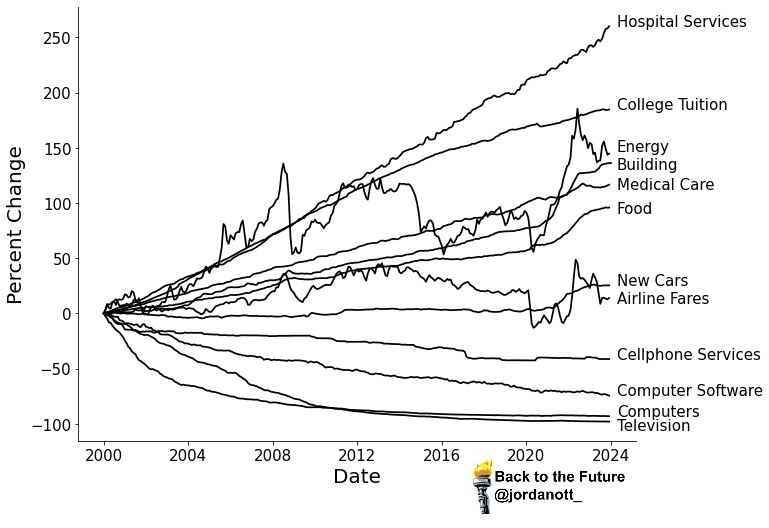

In [79]:
average_by_year = df[["Year", "Percent Change", "Category"]].groupby(["Category", "Year"]).mean().reset_index()

plt.figure(figsize=(10, 8))
# sns.lineplot(x="Date", y="Percent Change", data=df, hue="Category")
# plt.axhline(y=cpi_relative_to_2000["Percent Change"].values[-1], ls="--")
plt.legend([],[], frameon=False)

for category_name in df.Category.unique():
    category = df[df.Category == category_name]
    last_y = category["Percent Change"].values[-1]

    color = color_palette[sorted_categories.index(category_name)]
    sns.lineplot(x="Date", y="Percent Change", data=category, color="black")

    offset = offsets.get(category_name, 0)

    ax = plt.gca()
    xticks = ax.get_xticks()
    
    category_name = category_name.replace("_", " ").title()
    plt.text(xticks[-2] + 100, last_y + offset, category_name, fontsize=15)

helper.add_logo(ax=ax, location=(0.85, -0.1))

helper.savefig("../images/stagnation_plot")

## Total Pages in Federal Regulations
Raw data pulled from [here](https://regulatorystudies.columbian.gwu.edu/sites/g/files/zaxdzs4751/files/2022-11/totalpagescodefedreg_11-01-2022.csv)

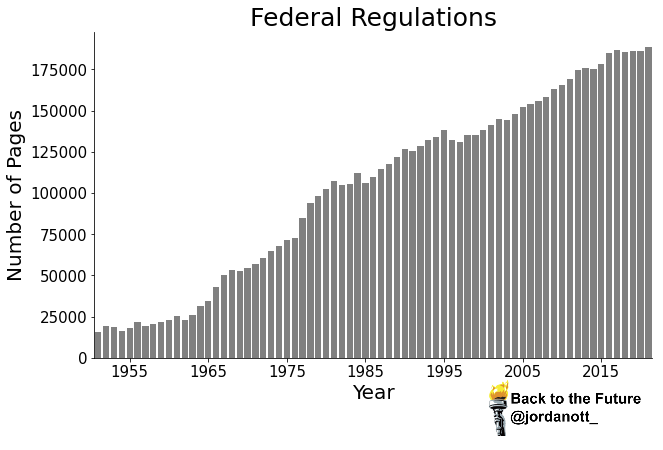

In [80]:
total_pages = pd.read_csv("../raw_data/government/total_pages_code_of_federal_regulations.txt")
ax = sns.barplot(x="Year", y="Total Pages", data=total_pages, color="gray")

years = sorted(total_pages.Year.values)
plt.title("Federal Regulations", fontsize=25)
plt.ylabel("Number of Pages")
ax.set_xticks(range(4, len(years), 10), years[4::10]);

helper.add_logo(ax=ax)

helper.savefig("../images/total_pages_cfr")

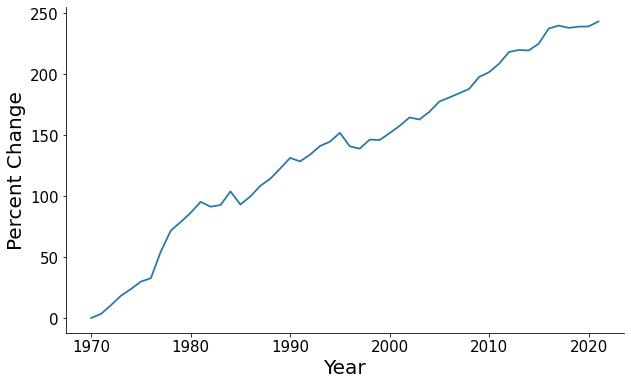

In [81]:
total_pages = helper.percent_change_relative_to(total_pages, 1970, "Total Pages")

ax = sns.lineplot(x="Year", y="Percent Change", data=total_pages)